In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
import random
import sys; sys.path.insert(0, '../dpsom/')

from TempDPSOM import get_data_finance

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import seaborn as sns

In [5]:
data_train, data_eval, labels_train, labels_eval = get_data_finance(finance_data_path="../data/yf_basic_price_features.p", 
                                                                    N_companies_train=400, 
                                                                    T_finance_data=144, 
                                                                    scale_fin_data=StandardScaler())

In [27]:
EXP_NAME = 'hyperopt_LSTM_10_8-8_2021-03-22_a67e1'
tdpsom_dict = pickle.load(open('../logs/{}/output.p'.format(EXP_NAME), 'rb'))

## 1) initial look at the results

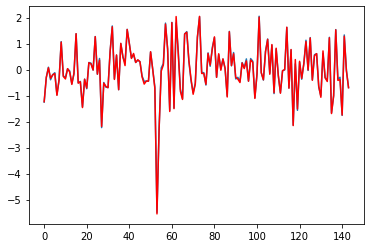

In [7]:
plt.plot(np.reshape(tdpsom_dict["x_rec_train"], (-1, 144, 7))[1, :, 0])
plt.plot(data_train[1, :, 0], color='red')
plt.show()

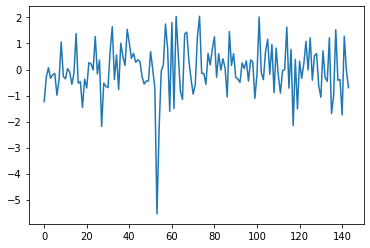

In [8]:
plt.plot(data_train[1, :, 0])

In [9]:
unique, counts = np.unique(tdpsom_dict["k_train"], return_counts=True)

In [10]:
unique

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64)

In [11]:
counts

array([ 819, 1070,  775,  844,  671,  606,  560,  600,  510,  687,  869,
       1356, 1243,  928,  731,  527,  534,  541,  839, 1518, 1808, 2408,
        730,  572,  391,  617,  969,  763,  352,  239,  342,  364,  510,
        692,  758,  629,  239,  262,  512,  855, 1065,  526,  665,  602,
        816, 1210, 1398, 1479,  858,  684,  746,  703,  552, 1661, 1067,
       1549, 1044,  946,  734,  796,  717,  273,  426, 1083], dtype=int64)

In [12]:
unique, counts = np.unique(tdpsom_dict["k_eval"], return_counts=True)

In [13]:
unique

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64)

In [14]:
counts

array([178, 228, 146, 186, 153, 149, 100, 125, 151, 127, 187, 288, 244,
       219, 138, 106, 122, 104, 193, 350, 385, 551, 192, 130,  78, 118,
       212, 163,  79,  51,  92, 107, 100, 148, 169, 151,  41,  61, 103,
       177, 227, 130, 129, 138, 196, 279, 272, 303, 210, 147, 173, 163,
       144, 344, 253, 360, 255, 213, 146, 219, 160,  61, 102, 294],
      dtype=int64)

## 2) compute metrics

In [15]:
def compute_metrics(data_train, data_eval, save_dict, N_companies=4, seed=42, T=144, pred_steps=10, som_grid=[2,2]):
    
    results = {}
        
    # due to strange implementation of batching in T-DPSOM
    N_train = int(len(save_dict["x_rec_train"]) / T)
    N_eval = int(len(save_dict["x_rec_eval"]) / T)
    data_train = data_train[:N_train].copy()
    data_eval = data_eval[:N_eval].copy()
    nr_features = data_train.shape[-1]
    
    # reconstruction loss
    x_rec_train = np.reshape(save_dict["x_rec_train"], (-1, T, nr_features))
    x_rec_eval = np.reshape(save_dict["x_rec_eval"], (-1, T, nr_features))
    results["recon_MSE_train"] = round(mean_squared_error(np.reshape(data_train, -1), np.reshape(x_rec_train, -1)), 4)
    results["recon_MSE_eval"] = round(mean_squared_error(np.reshape(data_eval, -1), np.reshape(x_rec_eval, -1)), 4)
    results["recon_MSE_train_returns"] = round(mean_squared_error(np.reshape(data_train[:, :, 0], -1), np.reshape(x_rec_train[:, :, 0], -1)), 4)
    results["recon_MSE_eval_returns"] = round(mean_squared_error(np.reshape(data_eval[:, :, 0], -1), np.reshape(x_rec_eval[:, :, 0], -1)), 4)
    
    # pred loss
    data_train_pred = data_train[:, 1:, :]  # shift
    data_eval_pred = data_eval[:, 1:, :]  # shift
    data_eval_pred = data_eval[:, -pred_steps:, :]  # consider only last part of time-series for LSTM preds 
    data_train_pred = data_train_pred[:, -pred_steps:, :]  # consider only last part of time-series for LSTM preds 
    x_preds_train = np.reshape(save_dict["x_preds_train"], (-1, T, nr_features))[:, :-1, :]  # shift
    x_preds_eval = np.reshape(save_dict["x_preds_eval"], (-1, T, nr_features))[:, :-1, :]  # shift
    x_preds_train = x_preds_train[:, -pred_steps:, :]  # consider only last part of time-series for LSTM preds 
    x_preds_eval = x_preds_eval[:, -pred_steps:, :]  # consider only last part of time-series for LSTM preds 
    
    results["preds_MSE_train"] = round(mean_squared_error(np.reshape(data_train_pred, -1), np.reshape(x_preds_train, -1)), 4)
    results["preds_MSE_eval"] = round(mean_squared_error(np.reshape(data_eval_pred, -1), np.reshape(x_preds_eval, -1)), 4) 
    results["preds_MSE_train_returns"] = round(mean_squared_error(np.reshape(data_train_pred[:, :, 0], -1), np.reshape(x_preds_train[:, :, 0], -1)), 4)
    results["preds_MSE_eval_returns"] = round(mean_squared_error(np.reshape(data_eval_pred[:, :, 0], -1), np.reshape(x_preds_eval[:, :, 0], -1)), 4)
    
    # clustering train
    clusters_train, clusters_size_train = np.unique(save_dict["k_train"], return_counts=True)
    nr_clusters = som_grid[0] * som_grid[1]
    results["clusters_train"] = (len(clusters_train), nr_clusters)
    for i, k in enumerate(clusters_train):
        results["cluster_{}".format(k)] = clusters_size_train[i]
    
    # clustering eval
    # TODO
      
    return results

In [16]:
compute_metrics(data_train, data_eval, tdpsom_dict)

{'recon_MSE_train': 0.0027,
 'recon_MSE_eval': 0.0031,
 'recon_MSE_train_returns': 0.0035,
 'recon_MSE_eval_returns': 0.0035,
 'preds_MSE_train': 2.6664,
 'preds_MSE_eval': 2.6954,
 'preds_MSE_train_returns': 4.205,
 'preds_MSE_eval_returns': 4.1932,
 'clusters_train': (64, 4),
 'cluster_0': 819,
 'cluster_1': 1070,
 'cluster_2': 775,
 'cluster_3': 844,
 'cluster_4': 671,
 'cluster_5': 606,
 'cluster_6': 560,
 'cluster_7': 600,
 'cluster_8': 510,
 'cluster_9': 687,
 'cluster_10': 869,
 'cluster_11': 1356,
 'cluster_12': 1243,
 'cluster_13': 928,
 'cluster_14': 731,
 'cluster_15': 527,
 'cluster_16': 534,
 'cluster_17': 541,
 'cluster_18': 839,
 'cluster_19': 1518,
 'cluster_20': 1808,
 'cluster_21': 2408,
 'cluster_22': 730,
 'cluster_23': 572,
 'cluster_24': 391,
 'cluster_25': 617,
 'cluster_26': 969,
 'cluster_27': 763,
 'cluster_28': 352,
 'cluster_29': 239,
 'cluster_30': 342,
 'cluster_31': 364,
 'cluster_32': 510,
 'cluster_33': 692,
 'cluster_34': 758,
 'cluster_35': 629,
 'clu

## 3) plot recons/preds

In [25]:
def plot_tdpsom_results(data_train, data_eval, EXP_NAME, N_companies=4, seed=42, T=144, pred_steps=10, nr_features=None):
    
    save_dict = pickle.load(open('../logs/{}/output.p'.format(EXP_NAME), 'rb'))
    
    
    # select companies for plotting
    N_train = int(len(save_dict["x_rec_train"]) / T)
    N_eval = int(len(save_dict["x_rec_eval"]) / T)
    
    if nr_features is None:
        nr_features = data_train.shape[2]
    
    random.seed(seed)
    train_companies = [(i, "train") for i in random.sample(list(range(N_train)), N_companies)]
    eval_companies = [(i, "eval") for i in random.sample(list(range(N_eval)), N_companies)]
    companies = train_companies + eval_companies

    for i, mode in companies:
        
        print("=================================== {}, company {} ====================================".format(mode, i))
        fig, axs = plt.subplots(nr_features, 3, figsize=(20, 5 * nr_features))

        if mode == "train":
            x = data_train[i]
        else:
            x = data_eval[i]
            
        x_rec = np.reshape(save_dict["x_rec_{}".format(mode)], (-1, T, data_train.shape[2]))[i]
        x_preds = np.reshape(save_dict["x_preds_{}".format(mode)], (-1, T, data_train.shape[2]))[i]
        k = np.reshape(save_dict["k_{}".format(mode)], (-1, T))[i]
        
        for j in range(nr_features):
            axs[j, 0].plot(x_rec[:, j], color="red", label="recons")
            axs[j, 0].plot(x[:, j], color="blue", label="ground-truth")
            axs[j, 0].set_title("Reconstructions, company {}-{}, feature {}".format(mode, i, j))

            preds = x_preds[:-1, j][-pred_steps:]
            ground_truths = x[1:, j][-pred_steps:]
            axs[j, 1].plot(preds, color="red", label="preds")
            axs[j, 1].plot(ground_truths, color="blue", label="ground-truth")
            axs[j, 1].set_title("Predictions, company {}-{}, feature {}".format(mode, i, j))
            
            axs[j, 2].plot(k)
            axs[j, 2].set_title("Clusters, company {}-{}".format(mode, i))
            
        plt.show()
    
    return train_companies, eval_companies

#### sanity check runs:

- VAE pretraining (200 epochs, latent_dim = 5): "hyperopt_LSTM_5_2-2_2021-03-22_59c01"
- VAE pretraining (200 epochs, latent_dim = 7): "hyperopt_LSTM_7_2-2_2021-03-22_1aff7"

=================================== train, company 234 ====================================


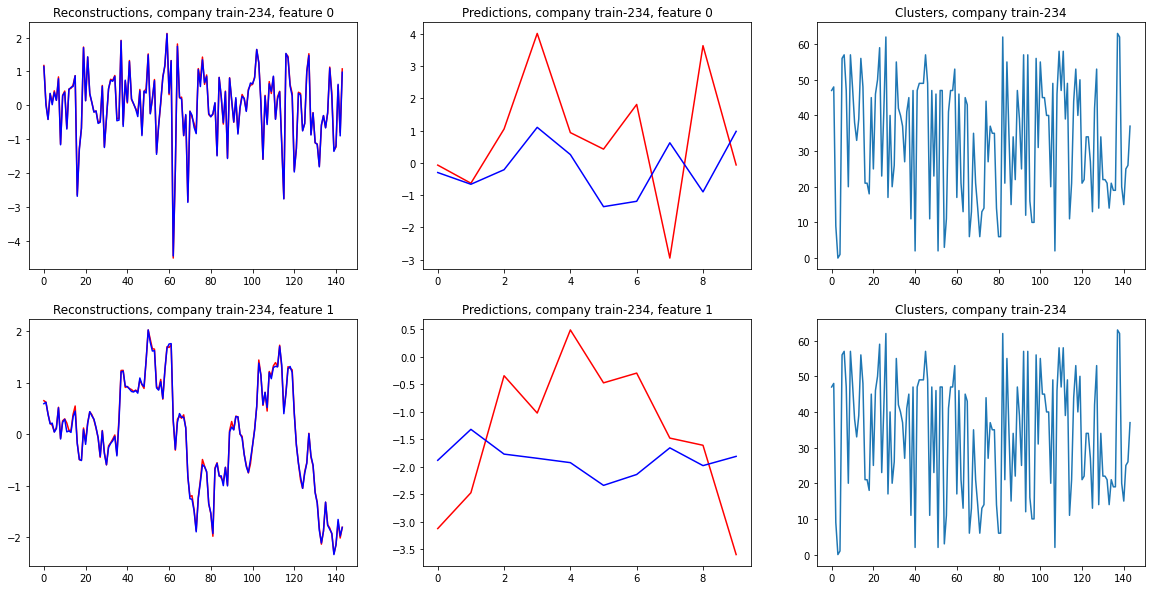

=================================== train, company 296 ====================================


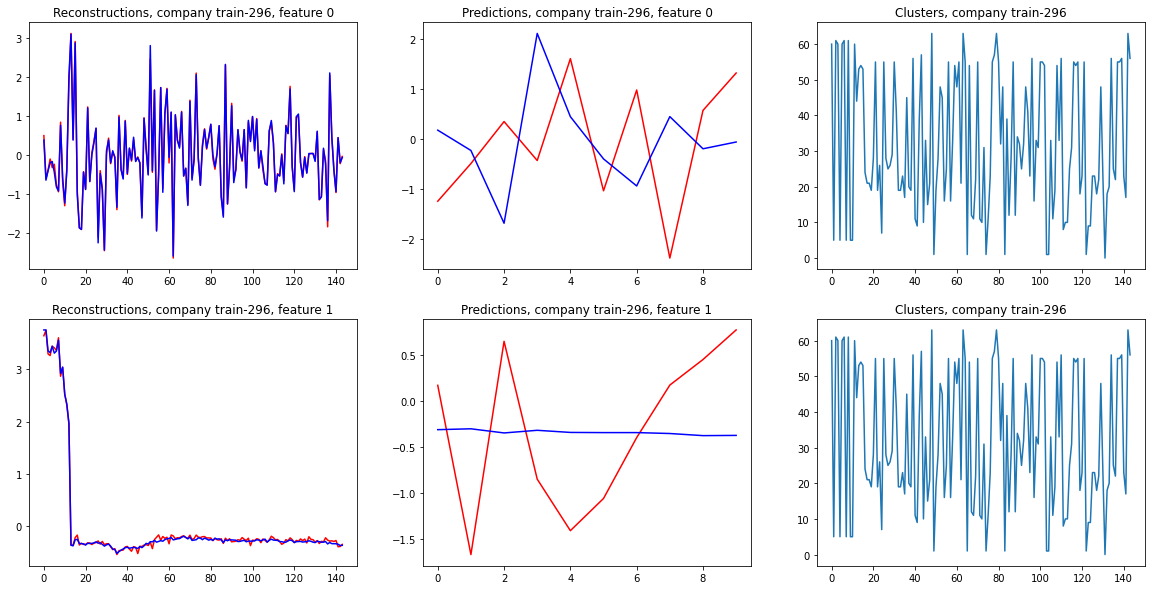

=================================== train, company 268 ====================================


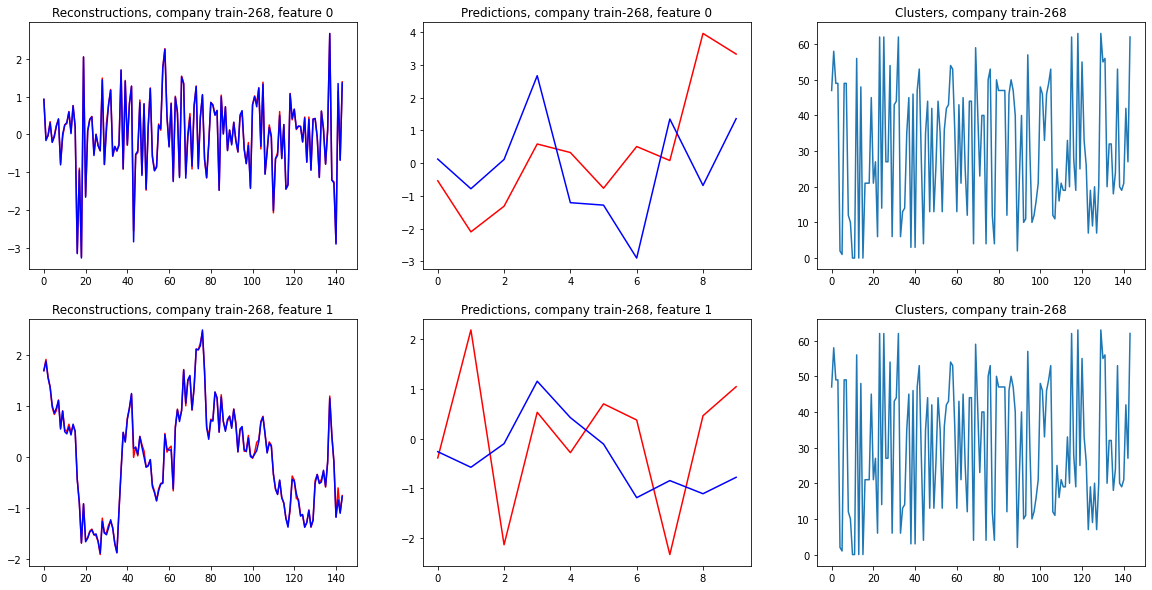

=================================== train, company 16 ====================================


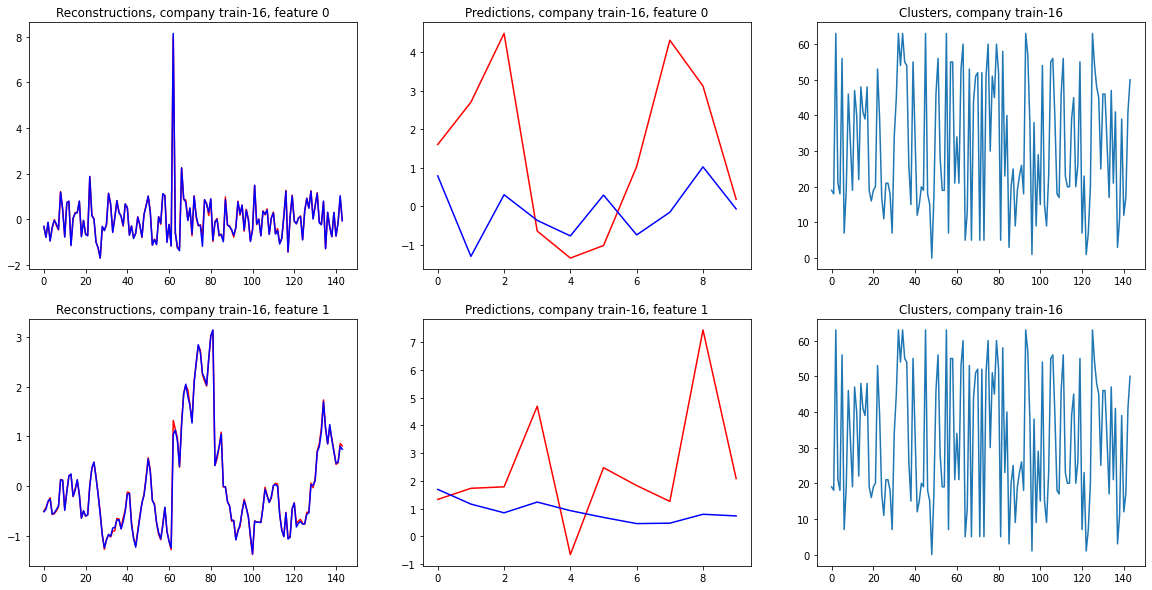

=================================== train, company 125 ====================================


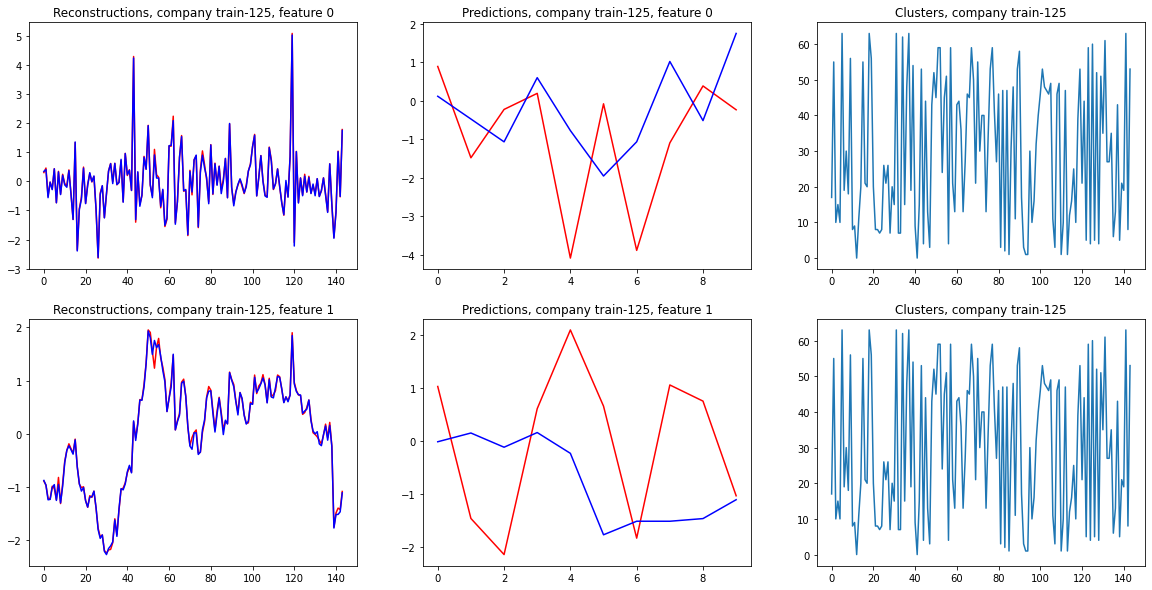

=================================== train, company 144 ====================================


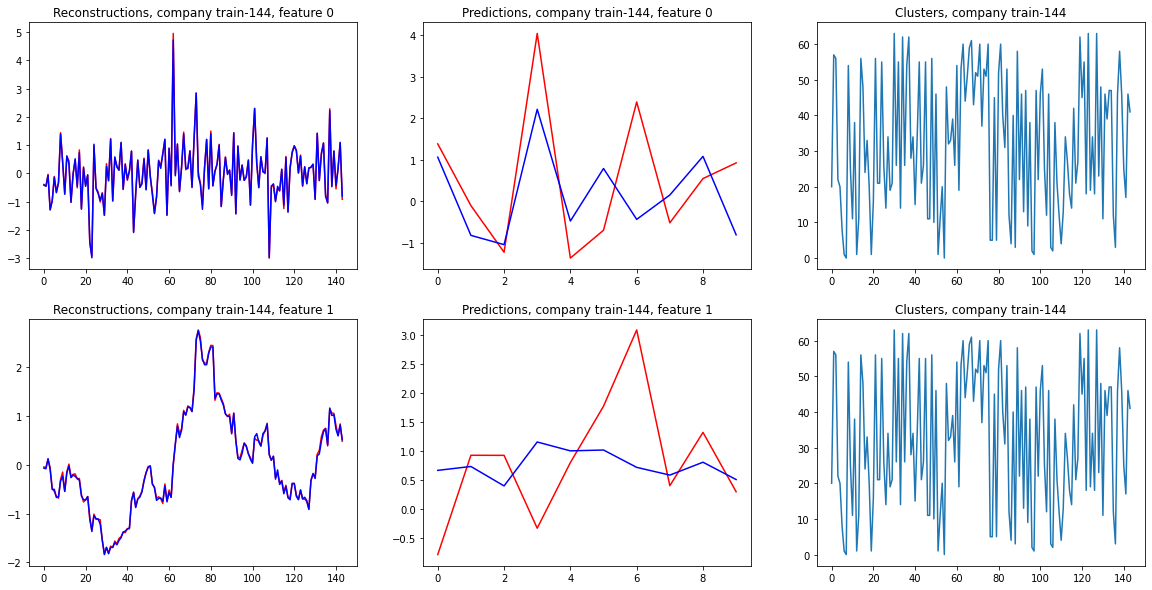

=================================== train, company 340 ====================================


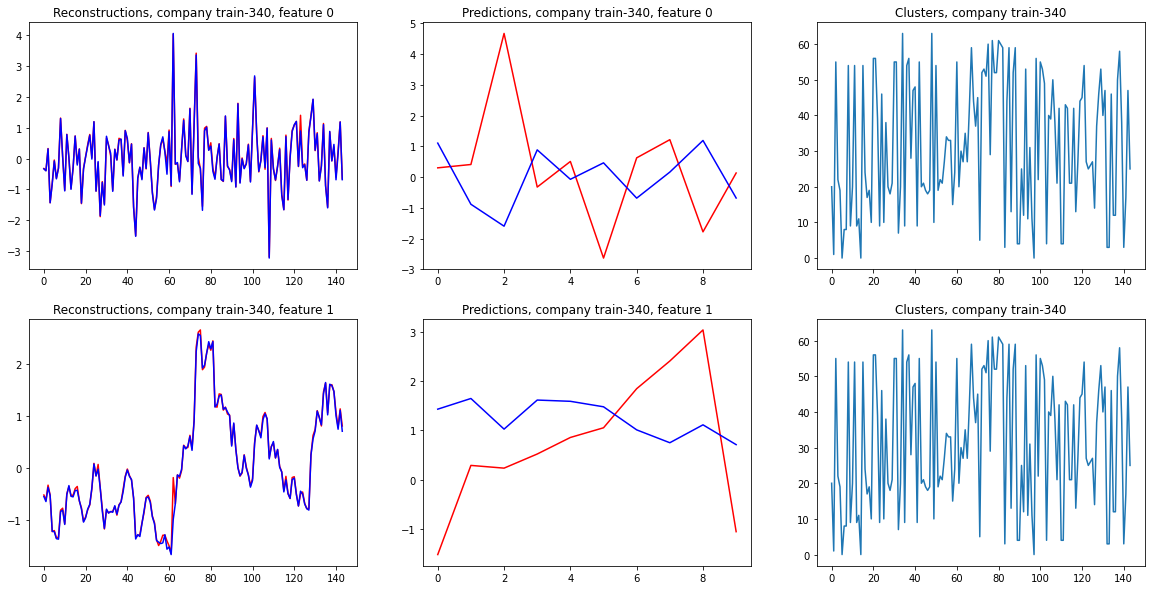

=================================== train, company 326 ====================================


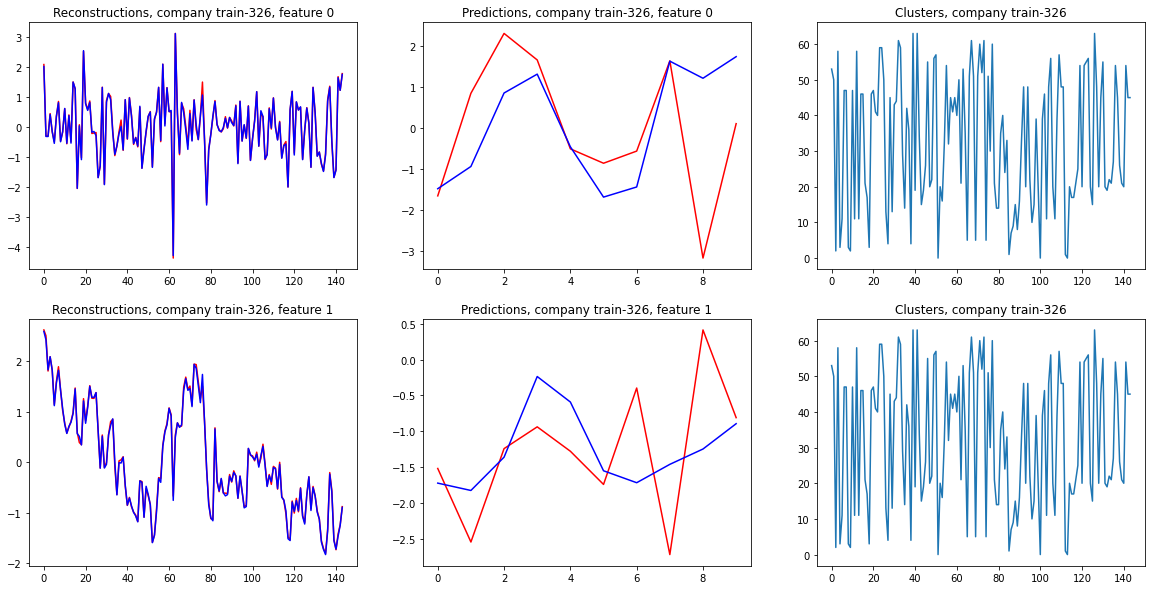

=================================== train, company 105 ====================================


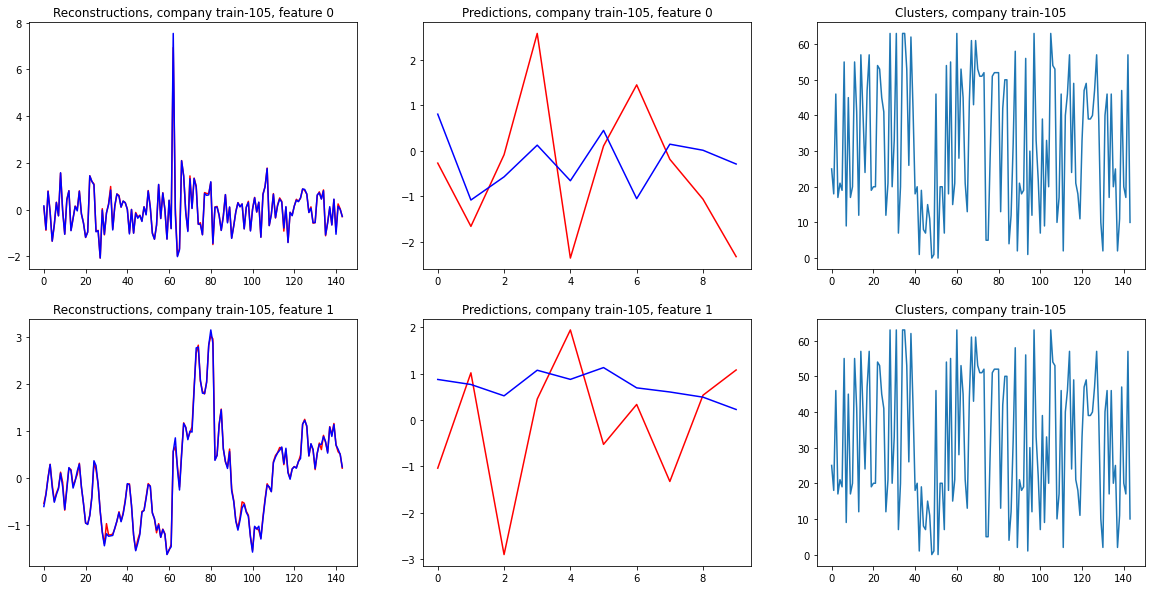

=================================== train, company 65 ====================================


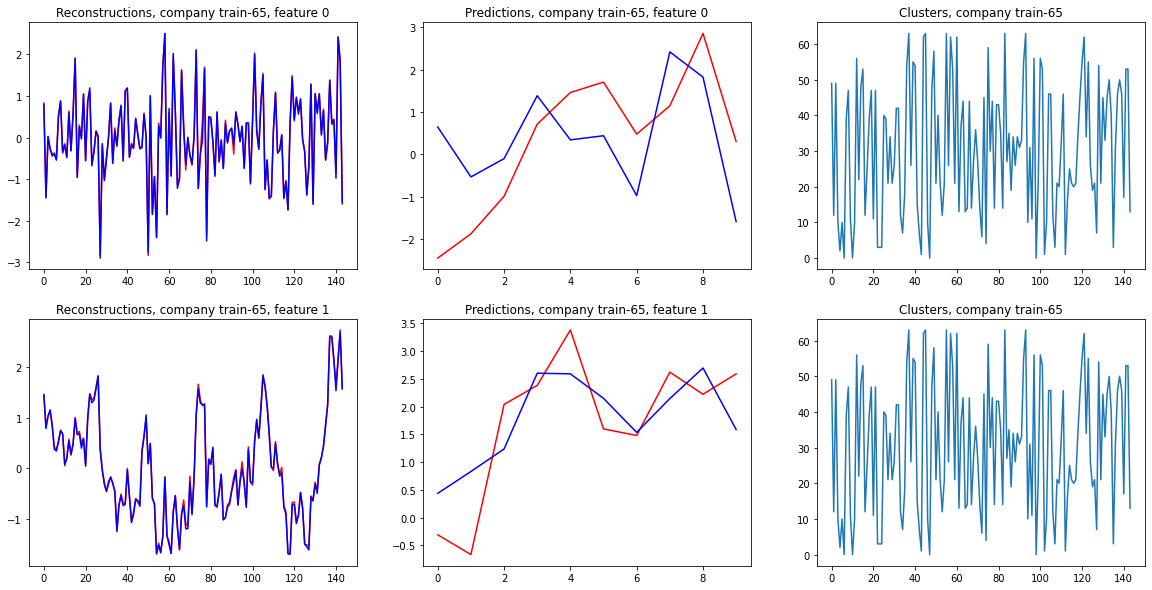

=================================== eval, company 44 ====================================


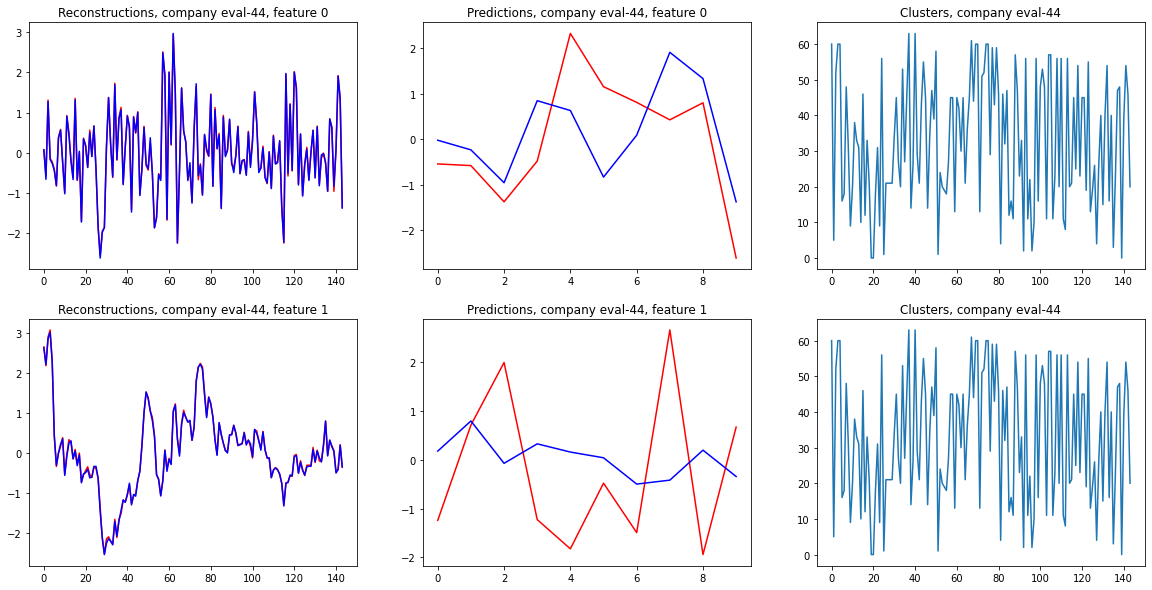

=================================== eval, company 35 ====================================


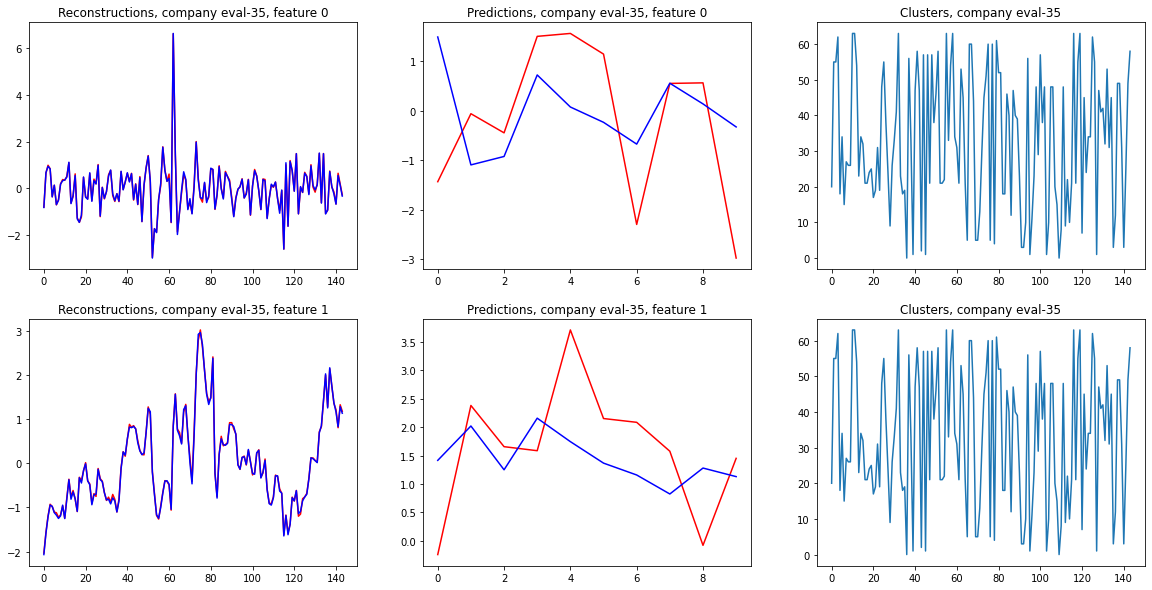

=================================== eval, company 56 ====================================


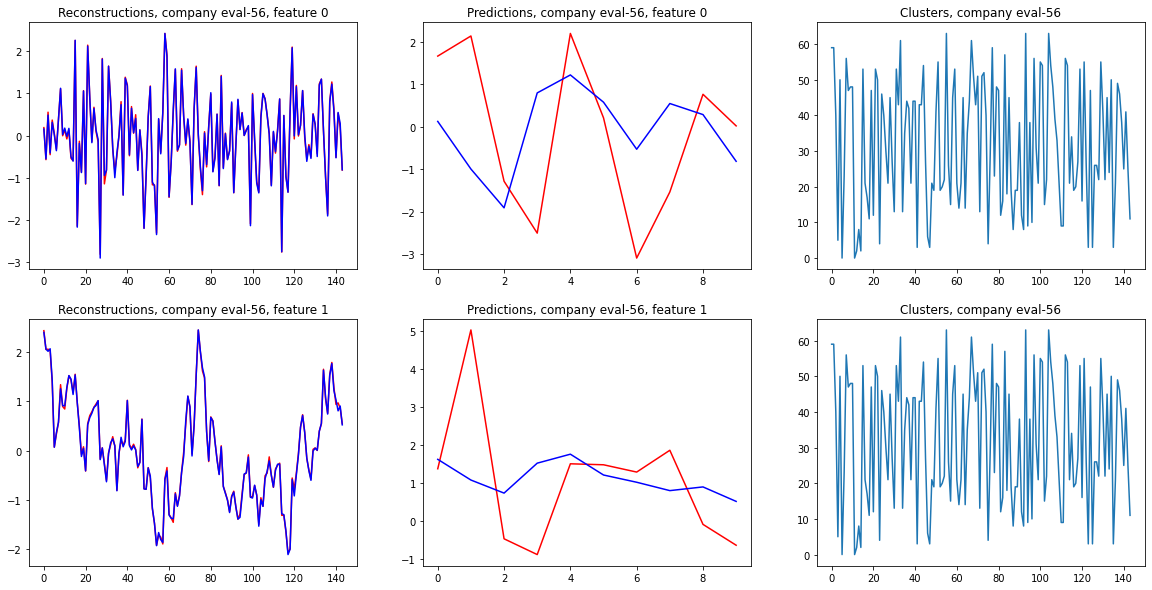

=================================== eval, company 3 ====================================


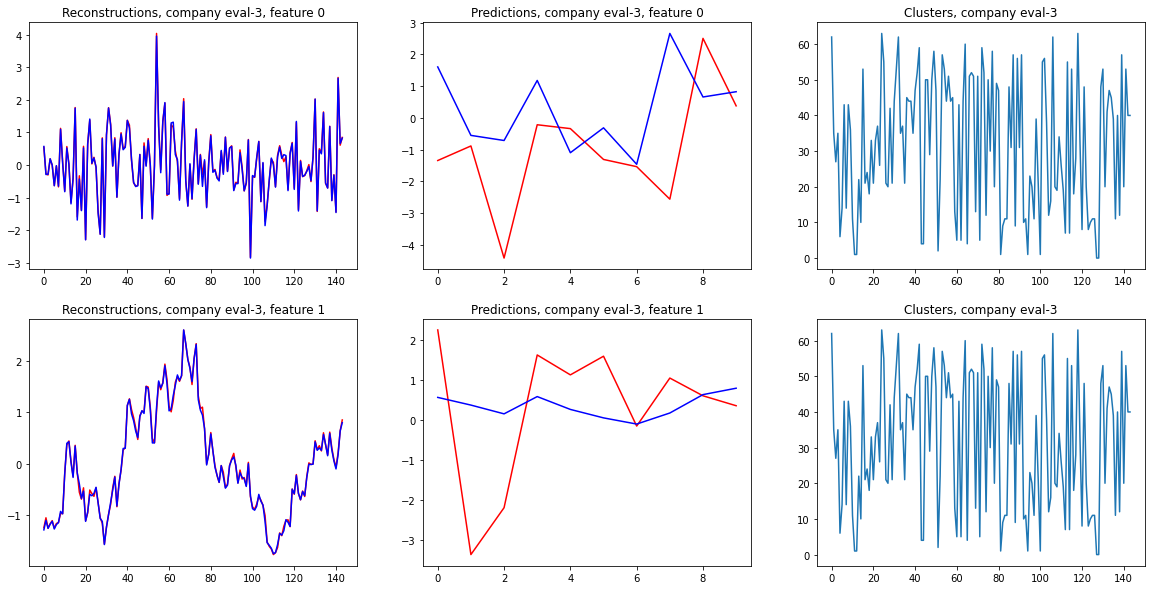

=================================== eval, company 67 ====================================


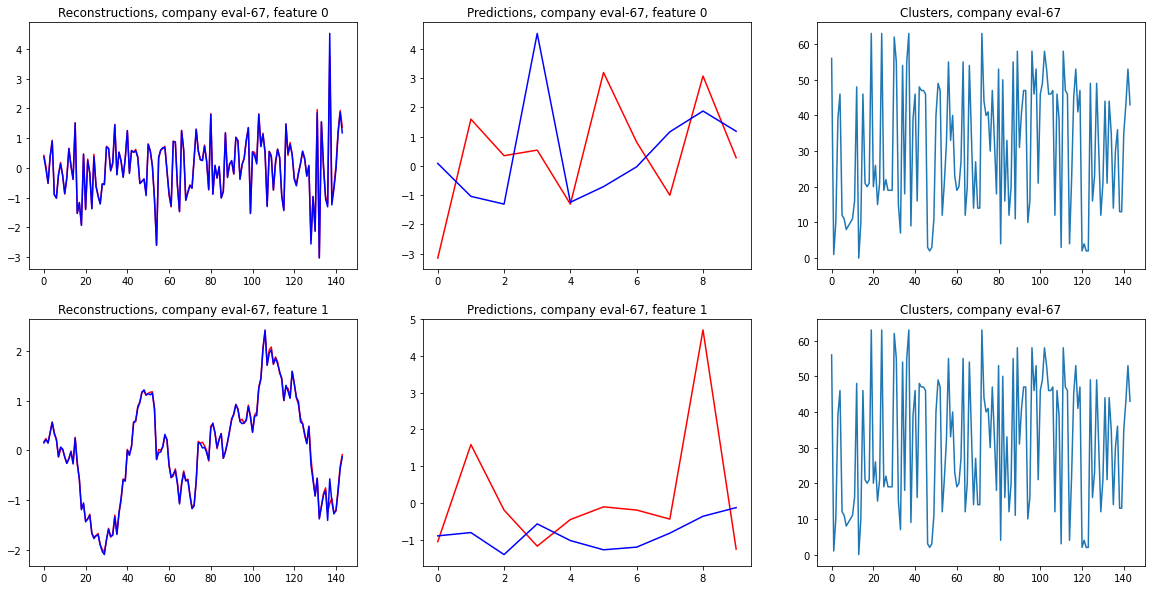

=================================== eval, company 16 ====================================


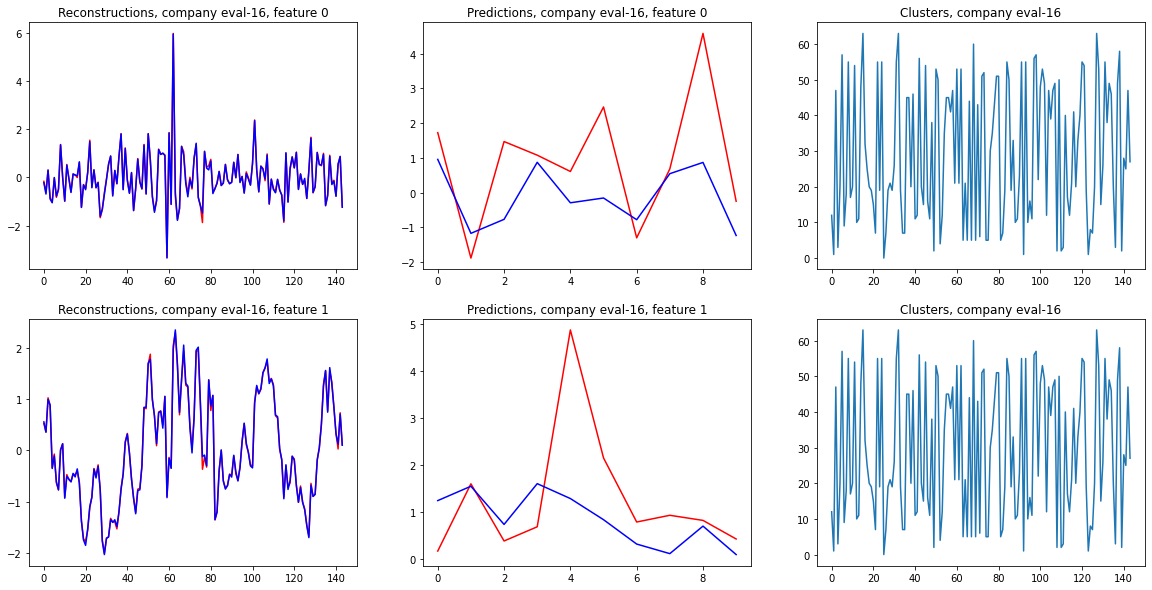

=================================== eval, company 7 ====================================


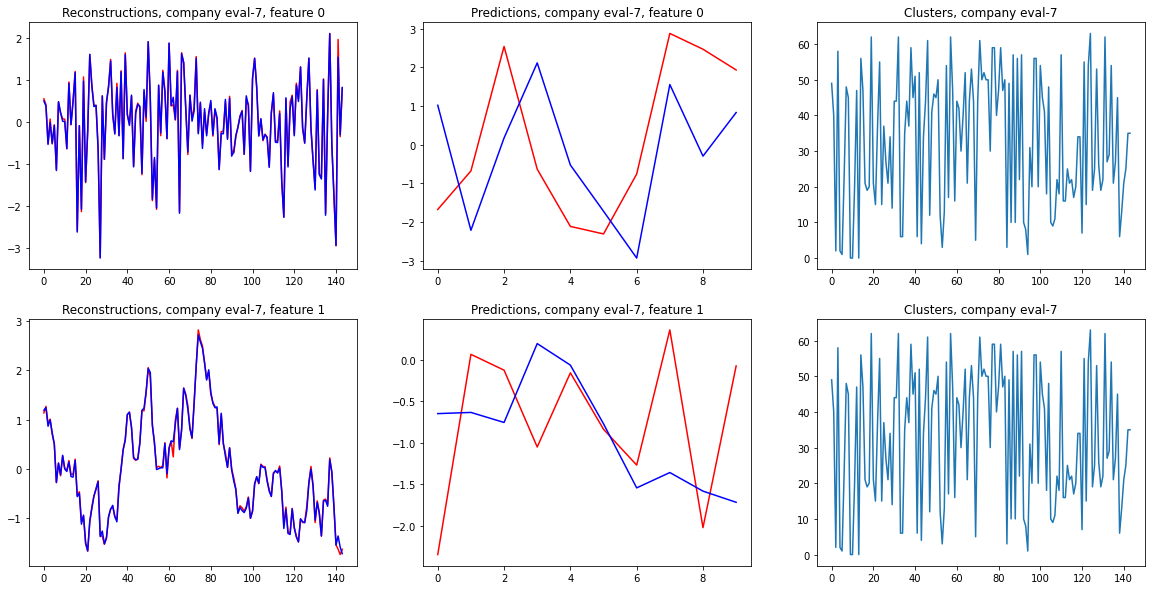

=================================== eval, company 25 ====================================


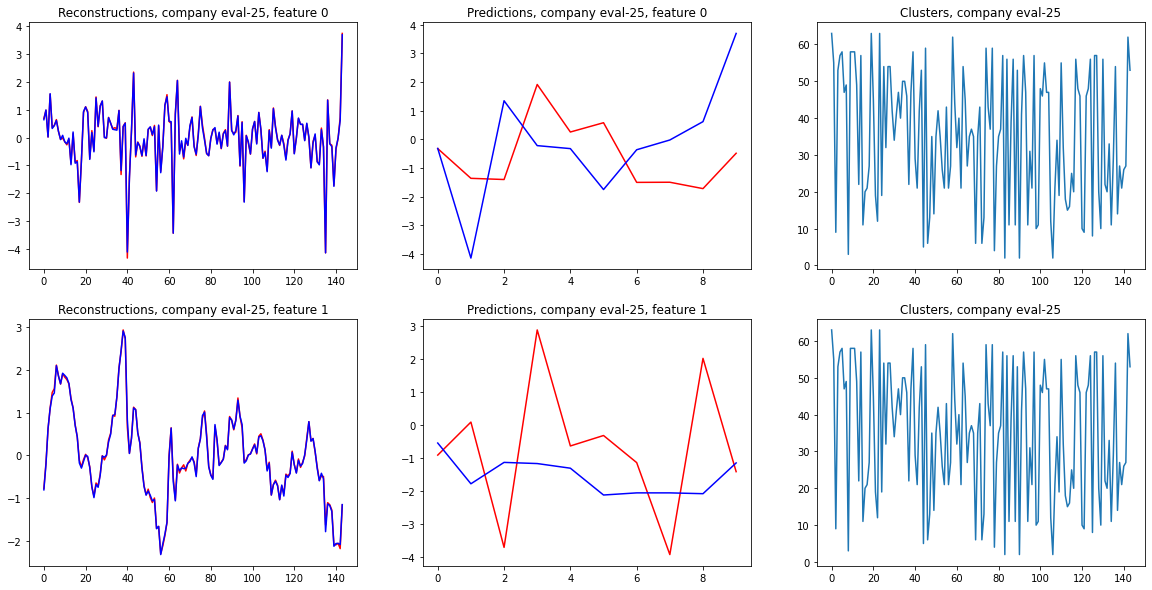

=================================== eval, company 58 ====================================


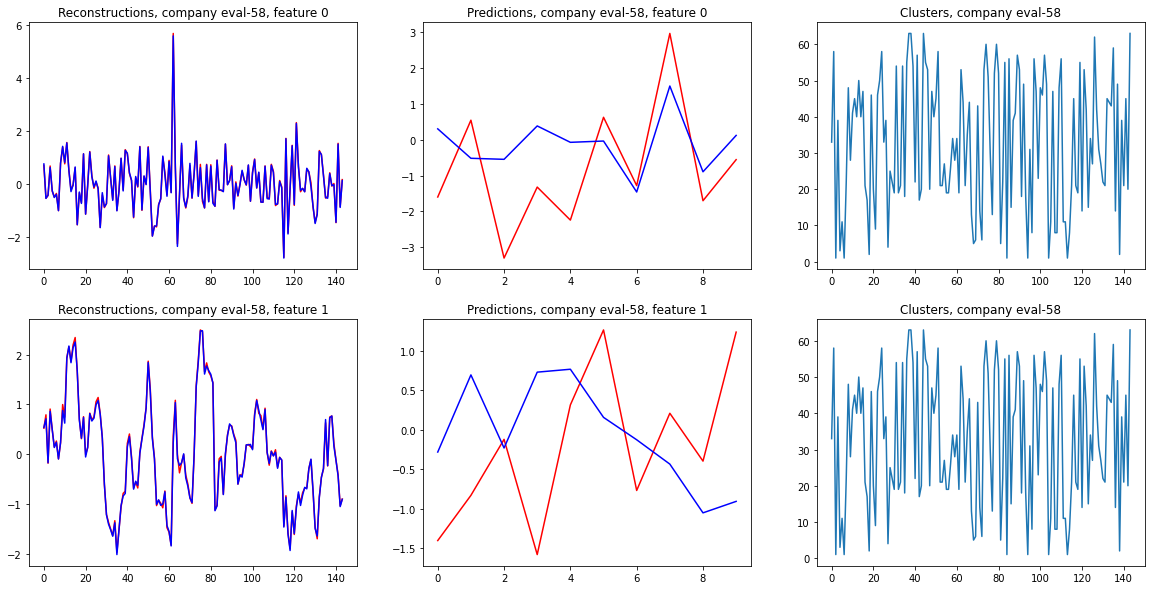

=================================== eval, company 6 ====================================


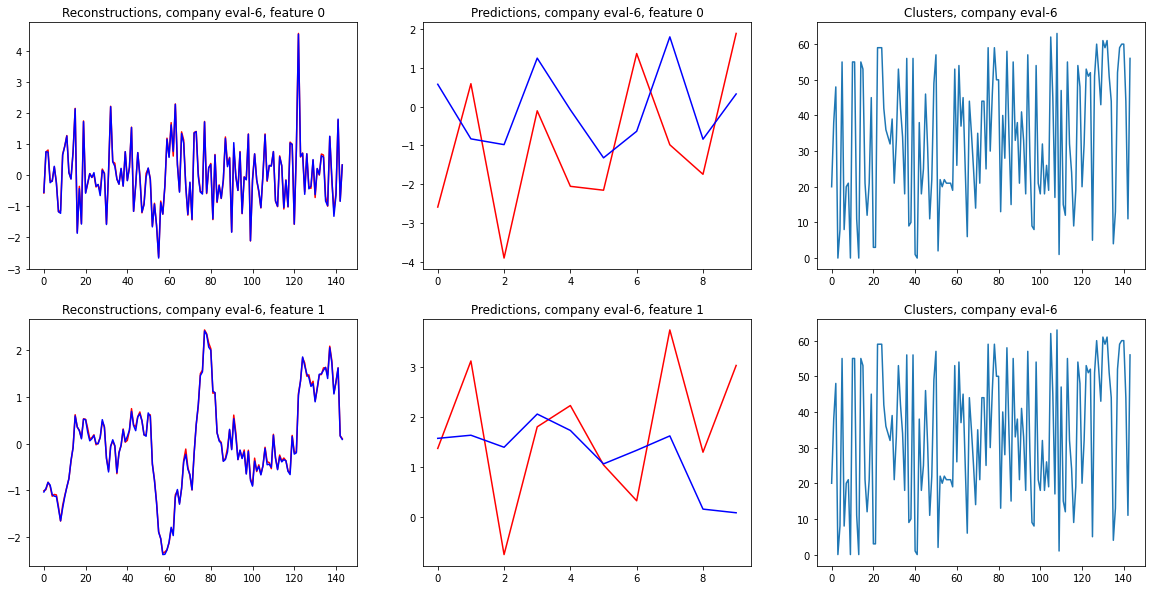

In [26]:
a, b = plot_tdpsom_results(data_train=data_train, data_eval=data_eval, EXP_NAME='hyperopt_LSTM_10_8-8_2021-03-22_a67e1', N_companies=10, seed=40, nr_features=2)

In [77]:
def plot_grid(data_train, exp_name, som_dim):
    
    save_dict = pickle.load(open('../logs/{}/output.p'.format(exp_name), 'rb'))
    
    N_train = int(len(save_dict["x_rec_train"]) / 144)
    k_all = save_dict["k_train"]
    
    nr_features = data_train.shape[-1]
    
    for j in range(nr_features):
        
        labels = np.reshape(data_train[:N_train][:, :, j], -1)
        
        f = plt.figure(figsize=(8,8))
        ones = np.ones((len(np.reshape(k_all, (-1)))))
        clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
        clust_matr2 = np.zeros(som_dim[0]*som_dim[1])
        for i in range(som_dim[0]*som_dim[1]):
            clust_matr1[i] = np.mean(labels[np.where(k_all==i)])
        clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))
        ax = sns.heatmap(clust_matr1, cmap="YlGnBu", annot=True, fmt='.3f')
        
        plt.title("Feature {}".format(j))
        plt.show()
    

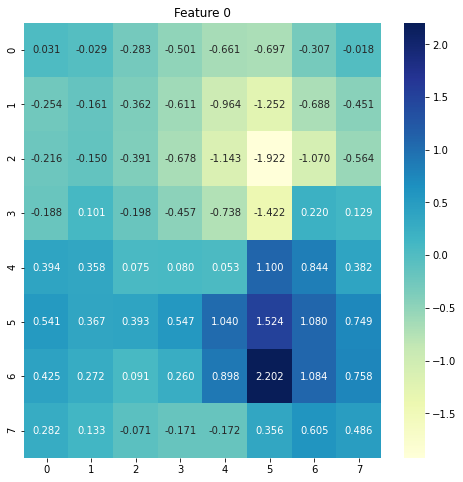

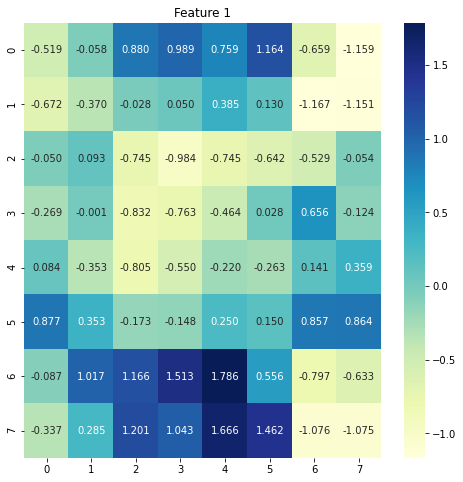

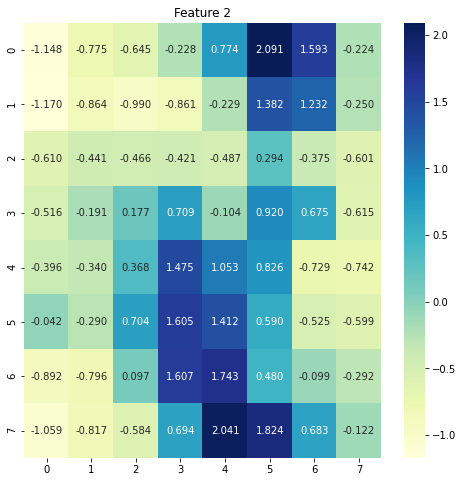

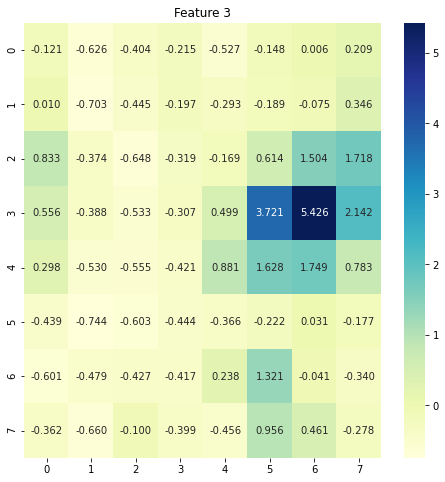

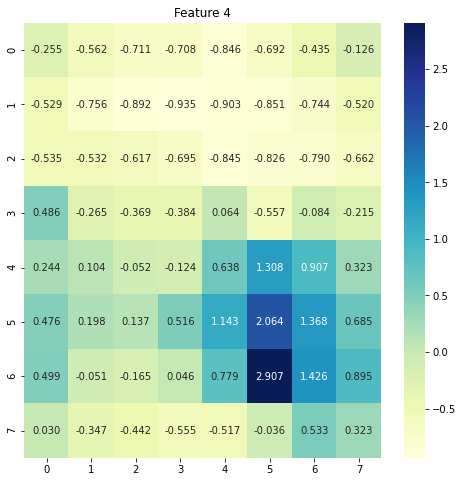

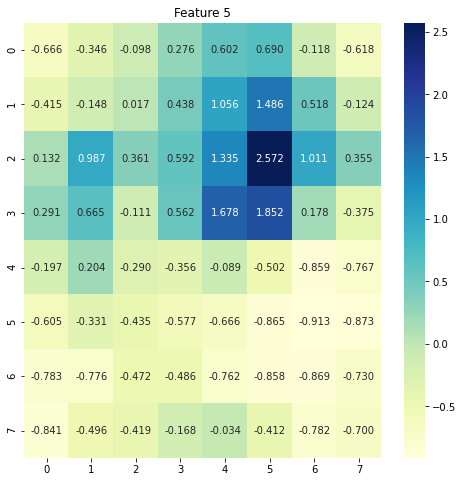

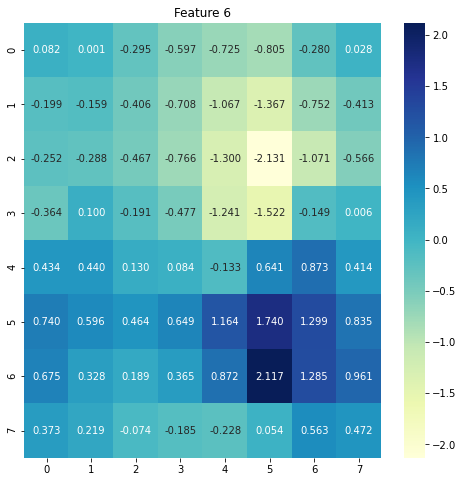

In [78]:
plot_grid(data_train=data_train, exp_name='hyperopt_LSTM_10_8-8_2021-03-22_a67e1', som_dim=[8,8])

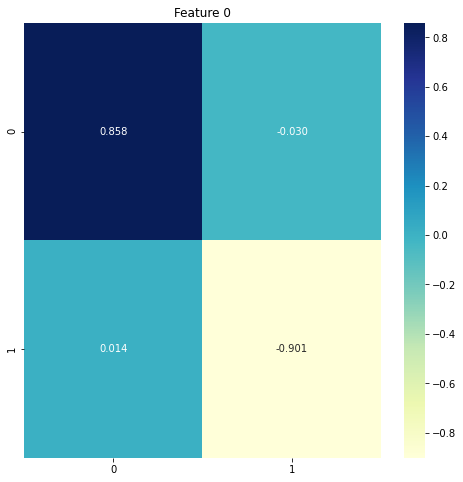

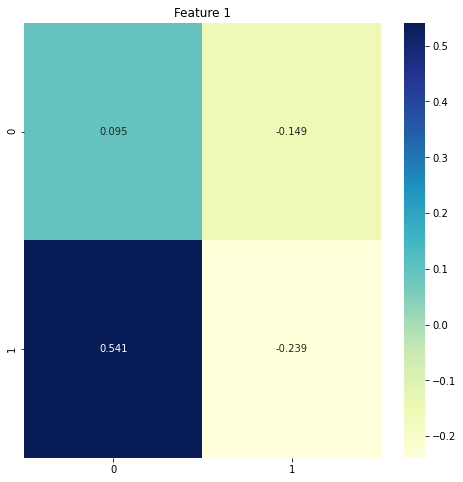

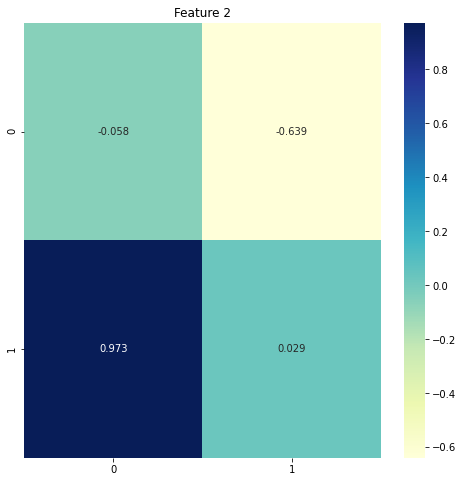

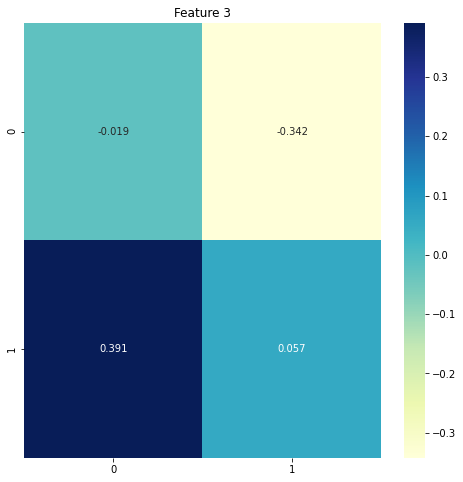

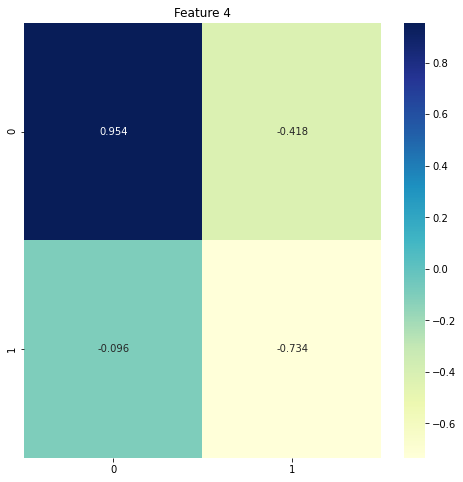

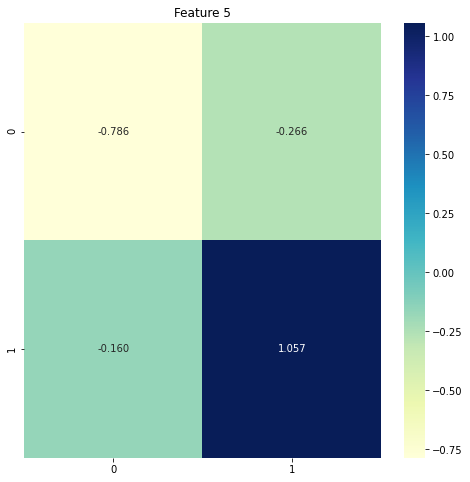

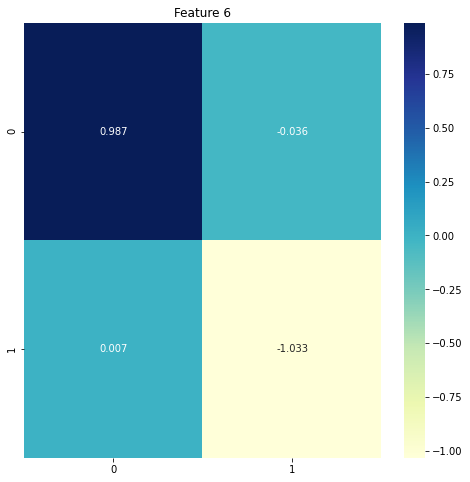

In [80]:
plot_grid(data_train=data_train, exp_name="hyperopt_LSTM_10_2-2_2021-03-22_aa878", som_dim=[2, 2])